## 手書き数値画像の補正
digits-svc-gui-modpil.pyは手書き数値画像の補正をしてから予測をしています。
補正は手書き数値画像の範囲をxy座標で記録しておき「認識」ボタンが押されたときに、
縦横比を保った状態で200x200ピクセルの画像に最大化しています。
1. draw_digit関数は、描画表示用のtk.Canvasのオブジェクトself.canvasと認識用のPIL.imageオブジェクトself.imgに黒丸を描画し座標の最大値と最小値を(self.drawxmin,self.drawymin),(self.drawxmax, self.drawymax)に記録します。
1. 「認識」ボタンが押されるとrecog関数が呼び出されます。
1. recog関数はPIL.imageオブジェクトを生成します。このオブジェクトにself.imgオブジェクトで描画された手書き数値画像を補正して貼り付けます。
1. 手書き数値画像の補正手順
 1. 画像を縦横比を調べ、長い方、例えば縦(y方向)が長ければ縦の長さを200ピクセルに変換します。
 1. 横(x方向)は縦横比を変えないように wr = 高さ最大値(h) * 画像の横幅(x) / 画像の高さ(y)を算出します。
 1. self.img.crop()は認識用オブジェクトself.imgから数値画像を描画した部分を抜き出します。
 1. self.resize()は抜き出した画像を最大化したサイズに変換します。
 1. recog_img.paste()は変換した認識画像tmp_imgをTkinterの表示用オブジェクトに貼り付けます。
1. 画像変換の過程を確認できるように画像を保存します。
 1. img0.npy tk.Imageオブジェクトに描画された画像
 1. img1.npy 数値画像の描画部分を抜き出した画像
 1. img2.npy 抜き出した画像を変換（最大化）した画像
 1. img3.npy 変換画像を中心に配置した認識用画像

### digits-svc-gui-mod-dbg.py

In [2]:
import numpy as np
from PIL import Image, ImageTk, ImageDraw, ImageFilter

import tkinter as tk  # for Python 3
    
class Application(tk.Frame):
    # 初期化用関数
    def __init__(self, clf, master=None):
        super().__init__(master)
        self.pack()
        self.clf = clf
        self.w = 200 # 一つの描画領域の幅
        self.h = 200 # 一つの描画領域の高さ
        self.d = 30  # マウスで描画する際の一点の直径
        #self.r = 20  # 旧バージョン用のフィルタ半径
        self.drawxmin = self.w  # 描画のxの最小座標（補正用）
        self.drawxmax = 0       # 描画のxの最大座標（補正用）
        self.drawymin = self.h  # 描画のyの最小座標（補正用）
        self.drawymax = 0       # 描画のyの最大座標（補正用）
        self.create_widgets()

    # 様々なGUI部品を構築
    def create_widgets(self):
        w = self.w
        h = self.h
        # マウスで描画するための領域
        self.canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.canvasを左端に配置
        self.canvas.grid(row=0, column=0)
        # self.canvasでマウスが動いた際にself.draw_digitが実行されるよう設定
        self.canvas.bind('<Button1-Motion>', self.draw_digit)

        # 認識用に用いる画像(self.canvasと共通化不能)
        self.img = Image.new('L', (w, h), color=255)
        # self.img上に描画するために必要なdraw
        self.draw = ImageDraw.Draw(self.img)

        # 認識用に self.img を加工して表示するキャンバス
        self.recog_canvas = tk.Canvas(self, width=w, height=h, bg='white')
        # self.recog_canvas上に描画するための画像を生成して関連付け
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # self.canvasを中央に配置
        self.recog_canvas.grid(row=0, column=1)

        # 結果表示用のキャンバス
        self.digit_canvas = tk.Canvas(self, width=w, height=h, bg='gray')
        # self.digit_canvasを右端に配置
        self.digit_canvas.grid(row=0, column=2)

        # 認識ボタン
        self.recog_btn = tk.Button(self, text='認識', command=self.recog)
        # 認識ボタンを下段左に配置
        self.recog_btn.grid(row=1, column=0)
        # クリアボタン
        self.clear_btn = tk.Button(self, text='クリア', command=self.clear)
        # クリアボタンを下段右に配置
        self.clear_btn.grid(row=1, column=2)

    # 認識ボタンが押されたときに実行される関数
    def recog(self):
        w = self.w
        h = self.h
        # 描画されたイメージを8x8のrecog_imgに縮小
        # 描画された数字を切り出し、認識エリア内に最大化
        if self.drawxmin<self.drawxmax and self.drawymin<self.drawymax:
            recog_img = Image.new('L', (w, h), color=255)
            if self.drawxmax - self.drawxmin >= self.drawymax - self.drawymin:  
                hr = int((self.drawymax - self.drawymin)*self.w / (self.drawxmax - self.drawxmin))
                h0 = int((h-hr)/2)
                tmp_img = self.img.crop((self.drawxmin, self.drawymin, self.drawxmax, self.drawymax))
                tmp_img = tmp_img.resize(size=(w, hr), resample=Image.BICUBIC)
                recog_img.paste(tmp_img, (0, h0, self.w, h0+hr))
            else:
                wr = int((self.drawxmax - self.drawxmin)*self.h / (self.drawymax - self.drawymin))
                w0 = int((w-wr)/2)
                np.save("img0",np.asarray(self.img, dtype=int)) # 画像をndarrayで保存
                tmp_img = self.img.crop((self.drawxmin, self.drawymin, self.drawxmax, self.drawymax))
                np.save("img1",np.asarray(tmp_img, dtype=int)) # 画像をndarrayで保存
                tmp_img = tmp_img.resize(size=(wr, h), resample=Image.BICUBIC)
                np.save("img2",np.asarray(tmp_img, dtype=int)) # 画像をndarrayで保存
                recog_img.paste(tmp_img, (w0, 0, w0+wr,self.h))
                np.save("img3",np.asarray(recog_img, dtype=int)) ## 画像をndarrayで保存
                print("wr: {} w0: {}".format(wr, w0))
                print("(w0, 0, w0+wr,self.h)",(w0, 0, w0+wr,self.h))
        else:
            recog_img = self.img
        # 位置と大きさを補正されたイメージを8x8のrecog_imgに縮小
        recog_img = recog_img.resize(size=(8,8), resample=Image.BICUBIC)

        # (8,8)のrecog_imgを描画用に拡大
        recog_img_large = recog_img.resize(size=(w, h))
        self.recog_img = ImageTk.PhotoImage(image=recog_img_large)
        self.recog_canvas.create_image((w/2, h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img

        # 8x8の画像を機械学習用に加工
        Ximg = np.asarray(recog_img, dtype=int)
        # 最大値を16に
        Ximg = 16*Ximg/255.0
        # 整数に丸める
        Ximg = Ximg.astype(int)
        # 白黒反転
        Ximg = 16-Ximg
        # 機械学習用データの完成
        X = np.array([Ximg.flatten()])
        # 最適化済みのサポートベクトルマシンから予測を取得
        y = self.clf.predict(X)
        # 予測結果を右の領域の表示
        self.digit_canvas.create_text(w/2, h/2, text = '{0:d}'.format(y[0]), fill='white', font = ('FixedSys', int(w/2)))

    # クリアボタンが押されたときに実行される関数
    def clear(self):
        w = self.w
        h = self.h
        # 左の描画領域をクリア
        self.canvas.delete('all')
        self.draw.rectangle(xy=[0,0,w,h], 
                            outline='white', fill='white')
        # 中央の認識領域をクリア
        self.recog_canvas.delete('all')
        self.recog_img = tk.PhotoImage(width=w, height=h)
        self.recog_canvas.create_image((w/2,h/2), image=self.recog_img, state='normal')
        self.recog_canvas.image = self.recog_img
        # 右の結果表示領域をクリア
        self.digit_canvas.delete('all')
        # 描画の座標の最小値と最大値をクリア
        self.drawxmin = w  # 描画のxの最小座標（補正用）
        self.drawxmax = 0  # 描画のxの最大座標（補正用）
        self.drawymin = h  # 描画のyの最小座標（補正用）
        self.drawymax = 0  # 描画のyの最大座標（補正用）

    # 左側の描画領域でマウスが動いたときに呼ばれる関数
    def draw_digit(self,event):
        d = self.d
        x = event.x
        y = event.y
        # 描画領域に黒丸を描画
        id=self.canvas.create_oval(x-d/2, y-d/2, x+d/2, y+d/2)
        self.canvas.itemconfigure(id, fill='black')
        # 認識用の画像に黒丸を描画
        self.draw.ellipse(xy=[x-d/2, y-d/2, x+d/2, y+d/2], fill=0, outline=0) 
        # 描画最小座標と最大座標を更新
        if x-d/2 < self.drawxmin:
            self.drawxmin = max(x-d/2, 0)
        if x+d/2 > self.drawxmax:
            self.drawxmax = min(x+d/2, self.w)
        if y-d/2 < self.drawymin:
            self.drawymin = max(y-d/2, 0)
        if y+d/2 > self.drawymax:
            self.drawymax = min(y+d/2, self.h)

if __name__ == '__main__':
    
    from sklearn import datasets, svm
    
    # 手書き数字のデータをロードし、変数digitsに格納
    digits = datasets.load_digits()
    
    # 特徴量のセットを変数Xに、ターゲットを変数yに格納
    X = digits.data
    y = digits.target
    
    # 分類用にサポートベクトルマシンを用意
    clf = svm.SVC(C=1.0, kernel='linear')
    # データに最適化
    clf.fit(X, y) 
    
    root = tk.Tk()
    app = Application(clf, master=root)
    app.master.title('数字認識（サポートベクトルマシン版、補正あり）')
    app.mainloop()

wr: 69 w0: 65
(w0, 0, w0+wr,self.h) (65, 0, 134, 200)
wr: 71 w0: 64
(w0, 0, w0+wr,self.h) (64, 0, 135, 200)
wr: 76 w0: 62
(w0, 0, w0+wr,self.h) (62, 0, 138, 200)
wr: 60 w0: 70
(w0, 0, w0+wr,self.h) (70, 0, 130, 200)


### img0.npy ～ img3.npyを表示するプログラム

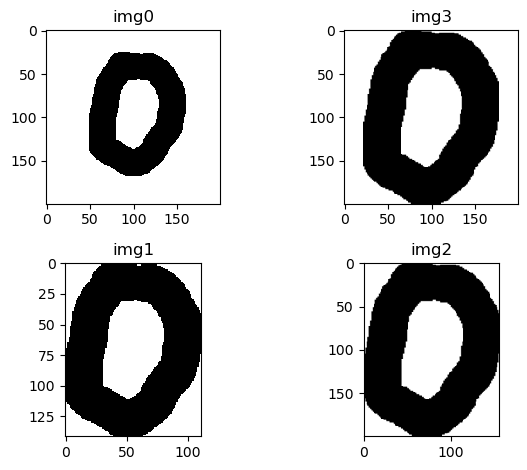

In [1]:
import matplotlib.pyplot as plt
import numpy as np

img = np.load("img0.npy")
plt.subplot(2, 2, 1)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
plt.title('img0')

img = np.load("img3.npy")
plt.subplot(2, 2, 2)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
plt.title('img3')

img = np.load("img1.npy")
plt.subplot(2, 2, 3)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
plt.title('img1')

img = np.load("img2.npy")
plt.subplot(2, 2, 4)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
plt.title('img2')

plt.tight_layout()
plt.show()


### PIL.Image.new(mode, size, color)
https://pillow.readthedocs.io/en/stable/reference/Image.html
https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
           
Line 34<br>       
self.img = Image.new('L', (w, h), color=255)<br>
'L' :8ビットピクセル白黒<br>
(w,L) :画像の幅と高さ<br>
color=255 :画像の色 255はRGBの白<br>